<a href="https://colab.research.google.com/github/adrielmori/Exemplo_APIRest_Java/blob/main/ht4m_master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Estudo de rotina do repositório 
##<font color = 'ocean'> *Hyperspectral Toolbox (HT4M)* em python

Autor: Adriel Lenner Vinhal Mori

Link para o repositório Git
- [Git - ht4m](https://github.com/dvlucena/ht4m)

Bibliografia
- [Dimensionality Reduction on HSI](https://https://colab.research.google.com/drive/1Lstx55MxHT8bpXlgnaXYloVCmagE_xC7?usp=sharing#scrollTo=xjpDyNm3fKMt)

- [Hyperspectral Image Analysis — Classification](https://towardsdatascience.com/hyperspectral-image-analysis-classification-c41f69ac447f)

In [1]:
!pip install earthpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 7.7 MB/s 
     |████████████████████████████████| 19.3 MB 374 kB/s 
     |████████████████████████████████| 1.0 MB 55.3 MB/s 
     |████████████████████████████████| 16.7 MB 54.8 MB/s 
     |████████████████████████████████| 6.3 MB 21.3 MB/s 


In [2]:
import scipy.io
import numpy as np
import h5py
import json

import os
from glob import glob
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
from random import sample

from mpl_toolkits import mplot3d
import numpy as np
from joblib import dump, load
import numpy.matlib
import pandas as pd
from mpl_toolkits.mplot3d import axes3d
from sklearn.cluster import KMeans
import pickle
#from spectral import *

from math import factorial
from sklearn.decomposition import PCA
from scipy.signal import savgol_filter
from sklearn.preprocessing import MinMaxScaler

import pprint
import seaborn as sn

import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import cv2

%matplotlib inline

In [3]:
!git clone https://github.com/dvlucena/ht4m.git

Cloning into 'ht4m'...
remote: Enumerating objects: 82, done.
remote: Total 82 (delta 0), reused 0 (delta 0), pack-reused 82
Unpacking objects: 100% (82/82), done.
Checking out files: 100% (20/20), done.


In [4]:
data_casca_maca = scipy.io.loadmat('/content/ht4m/data/banana/casca_maca.mat').get('casca_maca')
data_casca_nanica = scipy.io.loadmat('/content/ht4m/data/banana/casca_nanica.mat').get('casca_nanica')
data_casca_prata = scipy.io.loadmat('/content/ht4m/data/banana/casca_prata.mat').get('casca_prata')
data_polpa_maca = scipy.io.loadmat('/content/ht4m/data/banana/polpa_maca.mat').get('polpa_maca')
data_polpa_nanica = scipy.io.loadmat('/content/ht4m/data/banana/polpa_nanica.mat').get('polpa_nanica')
data_polpa_prata = scipy.io.loadmat('/content/ht4m/data/banana/polpa_prata.mat').get('polpa_prata')
# data_casca_marmelo = scipy.io.loadmat('/content/drive/MyDrive/UFG Remoto/5º Semestre/HSI/ht4m/data/banana/casca_marmelo/casca_marmelo.mat').get('casca_marmelo')

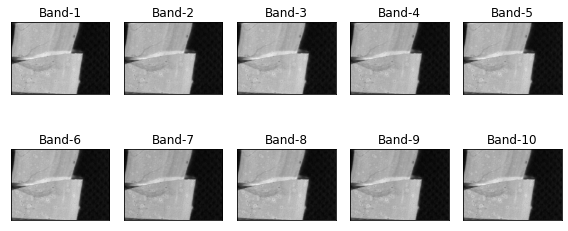

In [5]:
data = np.moveaxis(data_casca_maca, 2, 0)

ep.plot_bands(data[:10, :, :], title=[f'Band-{i}' for i in range(1, 11)], 
              cmap='gist_gray', cols=5, cbar=False, scale=True, figsize=(8, 4))
plt.show()

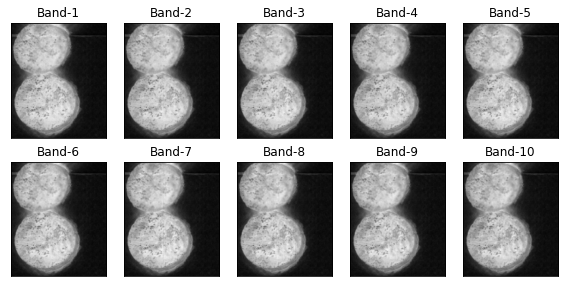

In [6]:
data = np.moveaxis(data_polpa_maca, 2, 0)
data.shape

ep.plot_bands(data[:10, :, :], title=[f'Band-{i}' for i in range(1, 11)], 
              cmap='gist_gray', cols=5, cbar=False, scale=True, figsize=(8, 4))
plt.show()

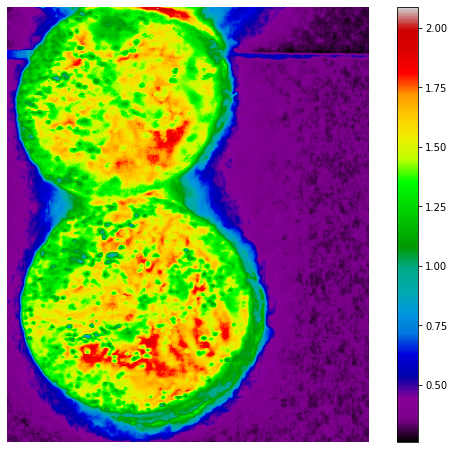

In [7]:
y = data[50,:,:]

plt.figure(figsize=(10, 8))
plt.imshow(y, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.show()

In [8]:
#Movendo os eixos da matriz para trabalhar com as bandas

def moveAxis(data):

  data = np.moveaxis(data, 2, 0)
  # ep.plot_rgb(data, title='Visualizando amostra', figsize=(8, 4))
  # plt.show()

  return data

In [9]:
#Retorna o rotulo de cada pixel ao seu correpondente clustercluster
#É executado empregando as classes com os algoritmos PCA e K-means

import pandas as pd

def hsiRemoveBackground(X = None, PCS = None): 

    scores = PCA(n_components=PCS).fit_transform(hsi2matrix(X))

    #Retorna a matriz com a remoção do fundo
    return  KMeans(n_clusters=2, init='k-means++', n_init=5, max_iter=300).fit(scores).labels_

In [10]:
def hsi2matrix(matrix: np.ndarray):
  
  return matrix.T.reshape((matrix.shape[1] * matrix.shape[2], matrix.shape[0]), order='F')

In [11]:
#Aplica os cluters na imagem para remover o fundo

def getClusters(image = None,INDEX = None, c = None, rgb = None):

      ind = realIdx(INDEX, c)
      out_i = np.concatenate((ind, ind, ind), axis=0).reshape((3, *(image.shape[:2])))

      if len(image.shape) == 2:
          image = MinMaxScaler(feature_range=(0, 1)).fit_transform(image)
          image = np.stack((image, image, image), axis=2)

      image[out_i[0] != 0, 0] = rgb[0]
      image[out_i[1] != 0, 1] = rgb[1]
      image[out_i[2] != 0, 2] = rgb[2]

      return image

In [12]:
def rgbscale(image):
        
    return (image * 255).astype(np.uint8)

In [13]:
def realIdx(idx, c):

      out = np.arange(idx.shape[0])
      for idx, (rid, vec) in enumerate(zip(out, idx)):
          if vec != c:
              out[idx] = -1
      out[out == -1] = 0

      return out

In [14]:
def sum_idx_array(idx):
      ind_r = []
      for i, (j, ind) in enumerate(zip(idx, np.arange(idx.shape[0]))):
          if j != ind:
              ind_r.append(i)

      return np.delete(idx, ind_r), np.array(ind_r)

In [15]:
def hex2rgb(value):
  return tuple(int(value.lstrip('#')[i:i + 2], 16) for i in (0, 2, 4))

In [16]:
#Cria uma matrix de indíces, de acordo com o idx e rmv da amostra

def rev_idx_array(idx, rmv, shape=None, tfill=None):

    if shape is None:
        out = np.zeros(idx.shape[0] + rmv.shape[0])
    else:
        out = np.zeros(shape)

    out[rmv] = 0

    if tfill is not None:
        for i, row in enumerate(idx):
            out[row] = tfill[i]
    else:
        out[idx] = 1

    return out.astype(int)

In [17]:
#Processamento da imagem amostrada em HSI resultando em imagens processadas em RGB da 
#espécie da banana 

def hsiImageProcess(CUBE = None, CUBE2 = None): 

    #CUBE -> polta e CUBE2 -> casca
    CUBE2 = moveAxis(CUBE2)
    INDEX2 = hsiRemoveBackground(CUBE2, 2) + 1
    image2 = CUBE2[50,:,:]

    out_i_casca = getClusters(image2, INDEX2, 1, (1, 0, 0))
    out_i2_casca = getClusters(image2, INDEX2, 2, (0, 1, 0))

    CUBE = moveAxis(CUBE)
    INDEX = hsiRemoveBackground(CUBE, 2) + 1
    image = CUBE[50,:,:]

    out_i_polpa = getClusters(image, INDEX, 1, (1, 0, 0))
    out_i2_polpa = getClusters(image, INDEX, 2, (0, 1, 0))

    plt.imshow(out_i_casca)
    plt.show()

    plt.imshow(out_i2_casca)
    plt.show()

    cluster = input('Is the cluster of interest red-1 or green-2?\n')

    ind2, rm2 = sum_idx_array(realIdx(INDEX2, int(cluster)))

    #Aplica valores de 0 e 1 para diferenciar label e fundo
    sample_cluster_casca = rev_idx_array(ind2, rm2)

    out_i_result2 = getClusters(image2, sample_cluster_casca, 1, (1, 0, 0))

    plt.imshow(out_i_polpa)
    plt.show()

    plt.imshow(out_i2_polpa)
    plt.show()

    cluster2 = input('Is the cluster of interest red-1 or green-2?\n')

    ind, rm = sum_idx_array(realIdx(INDEX, int(cluster2)))

    #Aplica valores de 0 e 1 para diferenciar label e fundo
    sample_cluster_polpa = rev_idx_array(ind, rm)

    out_i_result = getClusters(image, sample_cluster_polpa, 1, (1, 0, 0))

    # out_i_result_concatened = np.concatenate([out_i_result, out_i_result2])
    # fig = plt.figure(figsize = (16, 8))
    # print('\n ----Resulting processed sample---- \n')
    # plt.imshow(rgbscale(out_i_result_concatened))
    # plt.show()

    return ind, ind2, sample_cluster_polpa, sample_cluster_casca

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


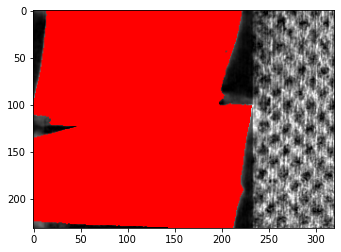

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


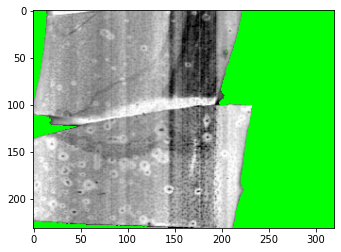

Is the cluster of interest red-1 or green-2?
1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


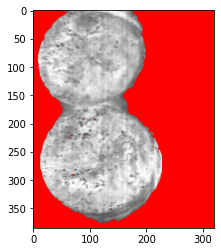

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


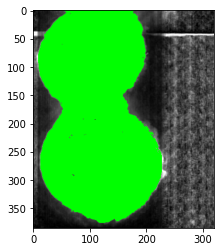

Is the cluster of interest red-1 or green-2?
2


In [18]:
ind_polpaMaca, ind_cascaMaca, sample_cluster_mp, sample_cluster_mc = hsiImageProcess(data_polpa_maca, data_casca_maca)
# print(ind_polpaMaca, sample_cluster_mp)

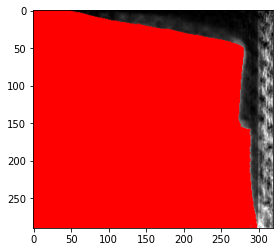

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


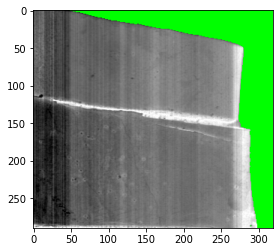

Is the cluster of interest red-1 or green-2?
1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


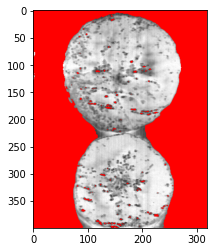

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


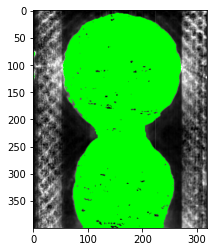

Is the cluster of interest red-1 or green-2?
2


In [19]:
ind_polpaNanica, ind_cascaNanica, sample_cluster_np, sample_cluster_nc  = hsiImageProcess(data_polpa_nanica, data_casca_nanica)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


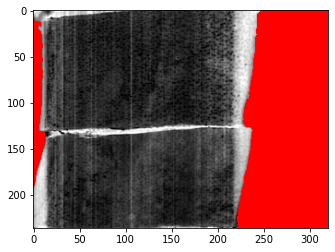

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


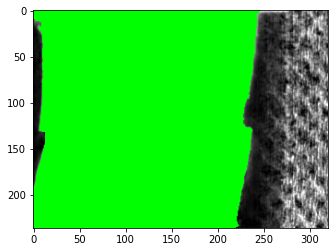

Is the cluster of interest red-1 or green-2?
2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


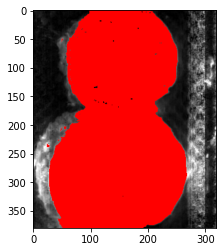

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


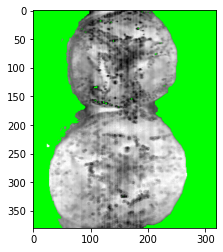

Is the cluster of interest red-1 or green-2?
1


In [20]:
ind_polpaPrata, ind_cascaPrata, sample_cluster_pp, sample_cluster_pc = hsiImageProcess(data_polpa_prata, data_casca_prata)

In [21]:
def visualizate_clusters(tittle, sample_cluster, image):

  image = moveAxis(image)
  image = image[50, :, :]
  out_i = getClusters(image, sample_cluster, 0, (1, 1, 1))
  plt.title(tittle)
  plt.imshow(rgbscale(out_i))
  plt.axis()
  plt.show()
  print('\n')

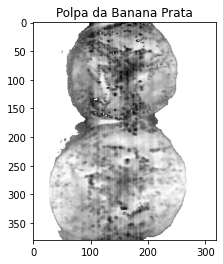

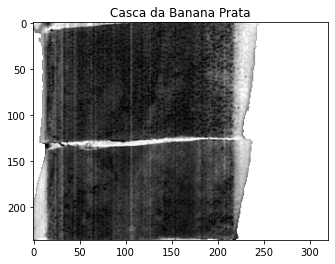

In [22]:
titulo1= 'Polpa da Banana Prata'
titulo2= 'Casca da Banana Prata'

visualizate_clusters(titulo1,sample_cluster_pp, data_polpa_prata)
visualizate_clusters(titulo2,sample_cluster_pc, data_casca_prata)

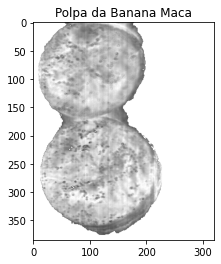

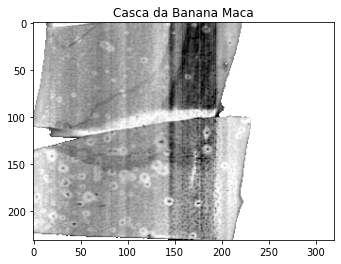

In [23]:
titulo1= 'Polpa da Banana Maca'
titulo2= 'Casca da Banana Maca'

visualizate_clusters(titulo1,sample_cluster_mp, data_polpa_maca)

visualizate_clusters(titulo2,sample_cluster_mc, data_casca_maca)

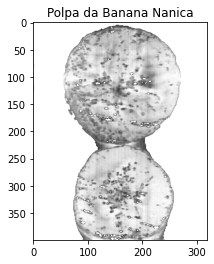

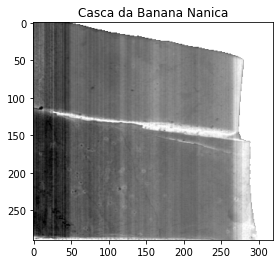

In [24]:
titulo1= 'Polpa da Banana Nanica'
titulo2= 'Casca da Banana Nanica'

visualizate_clusters(titulo1,sample_cluster_np, data_polpa_nanica)

visualizate_clusters(titulo2,sample_cluster_nc, data_casca_nanica)

#Teste Classificação

Rotina Repositório do Arthur Ricardo

In [25]:
from IPython.core.pylabtools import figsize
def visualization_sample_separation(image, sample_cluster, X_train_size=None, X_test_size=None):

  # classes_train_test=[1 ,2]

  # for classe in classes_train_test:
  #   image = getClusters(image, sample_cluster, classe, hex2rgb(colors[str(int(classe))]))
  #   # imageResult = getClusters(imageResult,full_array, classe, hex2rgb(colors[str(int(classe))]))

  image = getClusters(image, sample_cluster, 1, (1, 0, 0))
  image = getClusters(image, sample_cluster, 2, (0, 1, 0))

  red_patch = mpatches.Patch(color='red', label='Trian size')
  green_patch = mpatches.Patch(color='green', label='Test size')

  fig, ax = plt.subplots(figsize=(12,8))

  ax.axis()
  ax.imshow(rgbscale(image))

  fig.legend(handles=[red_patch, green_patch], loc='center right')

In [26]:
def get_Xy(data, test_size_data, sample_cluster, target, spectral_range=(0, 230)):

      data = moveAxis(data)

      y = np.array([])
      ind = np.array([])

      # print(data.shape)
      y_test = np.array([])
      y_train = np.array([])

      X_test = np.array([]).reshape(0, spectral_range[1] - spectral_range[0])
      X_train = np.array([]).reshape(0, spectral_range[1] - spectral_range[0])

      matrix = hsi2matrix(data)

      # matrix = matrix[:, spectral_range[0]:spectral_range[1]]

      ind, _ = sum_idx_array(realIdx(sample_cluster, 1))

      idx_train, idx_test = train_test_split(ind, test_size=test_size_data, shuffle=False)
      # print(idx_train.shape, idx_test.shape)

      X_test = np.concatenate((X_test, matrix[idx_test]))
      X_train = np.concatenate((X_train, matrix[idx_train]))

      # print(X_train, X_test)
      # print(idx_train, idx_test.shape)

      #Setando os targets

      y = np.ones(idx_test.shape) * target #Talvez o erro esteja aqui
      y_test = np.concatenate((y_test, y))

      y = np.ones(idx_train.shape) * target
      y_train = np.concatenate((y_train, y))

      # print(X_train, y_train, '\n', X_train.shape, y_train.shape)
      X_train, y_train = shuffle(X_train, y_train) #embaralhando dados de treino

      # Visualizando separação da amostra para treino e teste

      size_train = len(sample_cluster) * (1 - test_size_data)
      # print(sample_cluster.shape, size_train)

      X_train_separation = sample_cluster[:int(size_train)]
      X_test_separation = sample_cluster[len(X_train_separation):]

      # print(len(X_train_separation), len(X_test_separation), sample_cluster.shape)

      X_test_separation_aux = np.ones(len(X_test_separation)) * 2
      # print(len(X_test_separation))

      idx_test, rem = sum_idx_array(realIdx(X_test_separation, 1))

      X_test_separation = rev_idx_array(idx_test, rem, tfill=X_test_separation_aux)

      sample_cluster_visualizate = np.concatenate((X_train_separation, X_test_separation))
      # print(sample_cluster_visualizate, sample_cluster_visualizate.shape)
      
      visualization_sample_separation(data[50,:,:], sample_cluster_visualizate)

      return X_train, X_test, y_train, y_test

In [27]:
# teste2 = np.arange(48).reshape(-1, 4, 4) 
# kmeans_result = np.array([0, 0, 1, 1, 1, 1, 0,0, 1, 1, 1, 1])

# print(teste2)

# X_train0, X_test0, y_train1, y_test1 = get_Xy(teste2, 0.5, kmeans_result, 1)

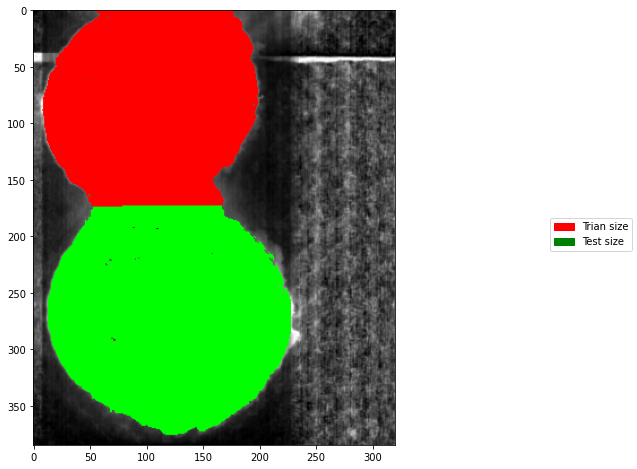

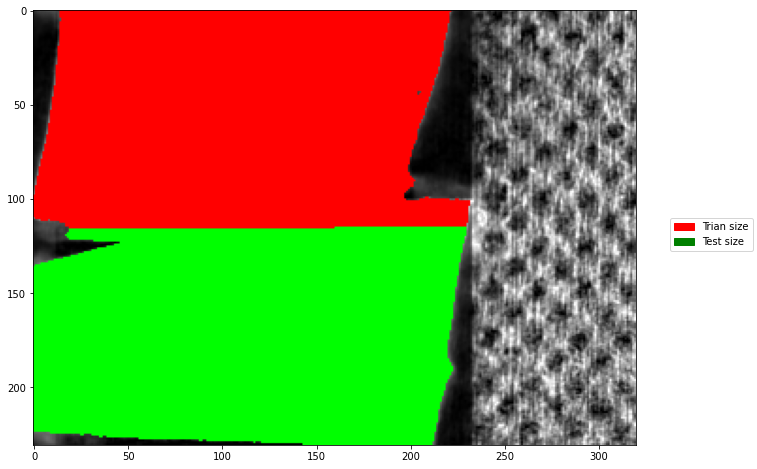

In [28]:
X_train_mp, X_test_mp, y_train_mp, y_test_mp = get_Xy(data_polpa_maca, 0.55 , sample_cluster_mp, 1)
X_train_mc, X_test_mc, y_train_mc, y_test_mc = get_Xy(data_casca_maca, 0.5 , sample_cluster_mc, 1)

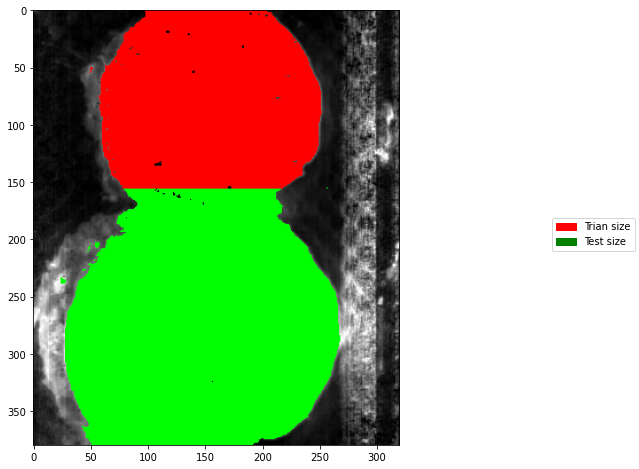

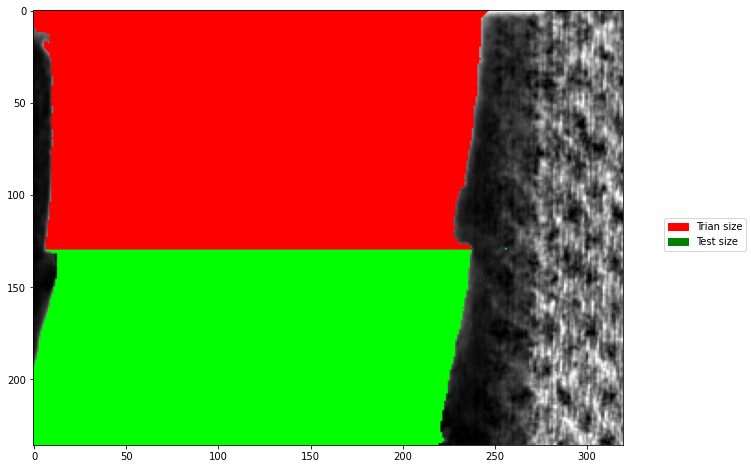

In [29]:
X_train_pp, X_test_pp, y_train_pp, y_test_pp = get_Xy(data_polpa_prata, 0.59, sample_cluster_pp, 2)
X_train_pc, X_test_pc, y_train_pc, y_test_pc = get_Xy(data_casca_prata, 0.45, sample_cluster_pc, 2)

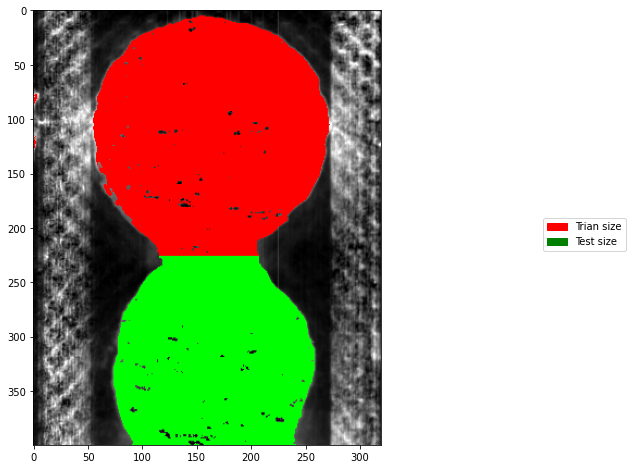

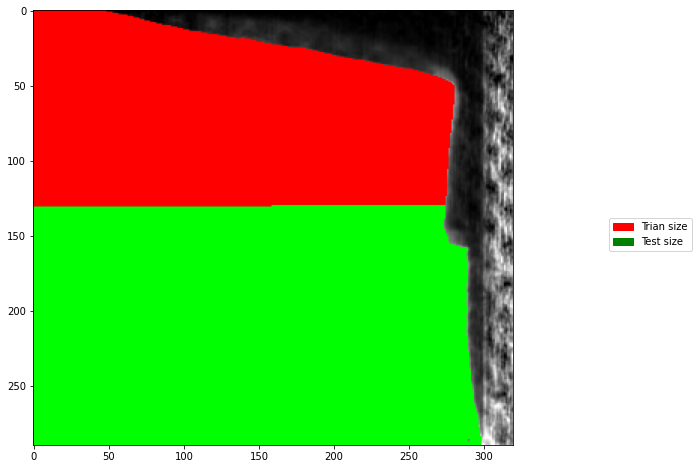

In [30]:
X_train_np, X_test_np, y_train_np, y_test_np = get_Xy(data_polpa_nanica, 0.435, sample_cluster_np, 3)
X_train_nc, X_test_nc, y_train_nc, y_test_nc = get_Xy(data_casca_nanica, 0.55, sample_cluster_nc, 3)

In [31]:
#Concatenando splits de treino e teste de cada amosta

# X_train = np.concatenate((X_train_mp, X_train_mc, X_train_np, X_train_nc, X_train_pp, X_train_pc), axis=0)
# y_train = np.concatenate((y_train_mp, y_train_mc, y_train_np, y_train_nc, y_train_pp, y_train_pc), axis=0)
# X_test = np. concatenate((X_test_mp, X_test_mc, X_test_np, X_test_nc, X_test_pp, X_test_pc), axis=0)
# y_test = np.concatenate((y_test_mp, y_test_mc, y_test_np, y_test_nc, y_test_pp, y_test_pc), axis=0)

# X_train = np.concatenate((X_train_mp, X_train_pp, X_train_np, X_train_mc, X_train_pc, X_train_nc))
# X_test = np. concatenate((X_test_mp, X_test_pp, X_test_np, X_test_mc, X_test_pc, X_test_nc))
# y_train = np.concatenate((y_train_mp, y_train_pp, y_train_np, y_train_mc, y_train_pc, y_train_nc))
# y_test = np.concatenate((y_test_mp, y_test_pp, y_test_np, y_test_mc, y_test_pc, y_test_nc))

X_train = np.concatenate((X_train_pp, X_train_pc, X_train_np, X_train_nc, X_train_mp, X_train_mc))
X_test = np. concatenate((X_test_pp, X_test_pc, X_test_np, X_test_nc, X_test_mp, X_test_mc))
y_train = np.concatenate((y_train_pp, y_train_pc, y_train_np, y_train_nc, y_train_mp, y_train_mc))
y_test = np.concatenate((y_test_pp, y_test_pc, y_test_np, y_test_nc, y_test_mp, y_test_mc))

##SVM Classification

In [37]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier

svc = SVC(verbose=2, kernel='rbf')

In [38]:
# svc.get_params()

In [ ]:
clf = OneVsRestClassifier(svc)

clf.fit(X_train, y_train)
y_pred_svc = clf.predict(X_test)

names = ['Banana_maca', 'Banana_prata', 'Banana_nanica']

data = confusion_matrix(y_test, y_pred_svc)
df_cm = pd.DataFrame(data, columns=np.unique(names), index = np.unique(names))

df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

#Plotando matriz de cunfusão
plt.figure(figsize = (10,8))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 20}, fmt='d')
plt.savefig('cmap.png', dpi=300)

print(classification_report(y_test, y_pred_svc, target_names = names))

[LibSVM][LibSVM]

##Random Forest Classification

In [ ]:
# def intervalo(results):
#     mean = results.mean()
#     dv = results.std()
#     print('Acurácia média: {:.2f}%'.format(mean*100))
#     print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'
#            .format((mean - 2*dv)*100, (mean + 2*dv)*100))

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import StratifiedKFold

# SEED = 42

# np.random.seed(SEED)

# X_train = np.concatenate((X_train, X_test))
# y_train = np.concatenate((y_train, y_test))

# cv = StratifiedKFold(n_splits=3, shuffle=True)

# clf = RandomForestClassifier()

# results = cross_val_score(clf, X_train, y_train, cv = cv, scoring = 'accuracy', verbose=2)

# intervalo(results)
# # clf.fit(X_train, y_train)

In [ ]:
# !pip install bayesian-optimization

In [ ]:
# from bayes_opt import BayesianOptimization
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold

# def stratified_kfold_score(clf,X,y,n_fold):
#     # X,y = X.values,y.values
#     strat_kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)
#     accuracy_list = []

#     for train_index, test_index in strat_kfold.split(X, y):
#         x_train_fold, x_test_fold = X[train_index], X[test_index]
#         y_train_fold, y_test_fold = y[train_index], y[test_index]
#         clf.fit(x_train_fold, y_train_fold)
#         preds = clf.predict(x_test_fold)
#         accuracy_test = accuracy_score(preds,y_test_fold)
#         accuracy_list.append(accuracy_test)

#     return np.array(accuracy_list).mean()

# def bo_params_rf(max_samples,n_estimators,max_features):
    
#     params = {
#         'max_samples': max_samples,
#         'max_features':max_features,
#         'n_estimators':int(n_estimators)
#     }

#     clf = RandomForestClassifier(max_samples=params['max_samples'],max_features=params['max_features'],n_estimators=params['n_estimators'])
#     score = stratified_kfold_score(clf,X_train, y_train,5)
    
#     return score

# rf_bo = BayesianOptimization(bo_params_rf, {
#                                               'max_samples':(0.5,1),
#                                                 'max_features':(0.5,1),
#                                               'n_estimators':(100,500)
#                                              })

# results = rf_bo.maximize(n_iter=200, init_points=20,acq='ei')

In [ ]:
# clf.get_params()

In [ ]:
# results = rf_bo.maximize(n_iter=200, init_points=20,acq='ei')

In [ ]:


ypred = clf.predict(X_test)

In [ ]:
names = ['Banana_maca', 'Banana_prata', 'Banana_nanica']

data = confusion_matrix(y_test, ypred)
df_cm = pd.DataFrame(data, columns=np.unique(names), index = np.unique(names))

df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

#Plotando matriz de cunfusão
plt.figure(figsize = (10,8))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 20}, fmt='d')
plt.savefig('cmap.png', dpi=300)

print(classification_report(y_test, ypred, target_names = names))

In [ ]:
ypred = clf.predict(X_train)

names = ['Banana_maca', 'Banana_prata', 'Banana_nanica']

data = confusion_matrix(y_train, ypred)
df_cm = pd.DataFrame(data, columns=np.unique(names), index = np.unique(names))

df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

#Plotando matriz de cunfusão
plt.figure(figsize = (10,8))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 20}, fmt='d')
plt.savefig('cmap.png', dpi=300)

print(classification_report(y_train, ypred, target_names = names))

##Decision Tree Classification

In [ ]:
# from sklearn.datasets import make_classification
# from sklearn import tree

# clf = tree.DecisionTreeClassifier()

# clf.fit(X_train, y_train)

# ypred = clf.predict(X_test)

# names = ['Banana_maca', 'Banana_prata', 'Banana_nanica']

# data = confusion_matrix(y_test, ypred)
# df_cm = pd.DataFrame(data, columns=np.unique(names), index = np.unique(names))

# df_cm.index.name = 'Actual'
# df_cm.columns.name = 'Predicted'

# #Plotando matriz de cunfusão
# plt.figure(figsize = (10,8))
# sn.set(font_scale=1.4)
# sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 20}, fmt='d')
# plt.savefig('cmap.png', dpi=300)

# print(classification_report(y_test, ypred, target_names = names))

In [ ]:
# #Acurária para treino

# ypred = clf.predict(X_train)

# names = ['Banana_maca', 'Banana_prata', 'Banana_nanica']

# data = confusion_matrix(y_train, ypred)
# df_cm = pd.DataFrame(data, columns=np.unique(names), index = np.unique(names))

# df_cm.index.name = 'Actual'
# df_cm.columns.name = 'Predicted'

# #Plotando matriz de cunfusão
# plt.figure(figsize = (10,8))
# sn.set(font_scale=1.4)
# sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 20}, fmt='d')
# plt.savefig('cmap.png', dpi=300)

# print(classification_report(y_train, ypred, target_names = names))

##Visualizar resultados

In [ ]:
# 1 -> maça
# 2 -> prata
# 3 -> nanica
colors = {
            '1': '#0000FF',#azul
            '2': '#00FF00',#verde
            '3': '#FF0000',#vermelho
        }

classes = [1,2,3]

In [ ]:
def result_visualization(data, sample_cluster, tittle, spectral_range=(0, 230)):
  
  data = moveAxis(data)

  matrix = hsi2matrix(data)
  matrix = matrix[:, spectral_range[0]:spectral_range[1]]

  ind, rem = sum_idx_array(realIdx(sample_cluster, 1))

  #model classification
  result = clf.predict(matrix[ind])

  full_array = rev_idx_array(ind, rem, tfill=result)

  imageResult = data[50,:,:]

  for classe in classes:    
    imageResult = getClusters(imageResult,full_array, classe, hex2rgb(colors[str(int(classe))]))

  #plotando a imagem
  blue_patch = mpatches.Patch(color='blue', label='Banana Maça')
  red_patch = mpatches.Patch(color='red', label='Banana Nanica')
  green_patch = mpatches.Patch(color='green', label='Banana Prata')

  fig, ax = plt.subplots(**{'figsize': (12, 8), 'dpi': 300})

  ax.axis('off')
  plt.title(tittle)
  ax.imshow(imageResult)

  fig.legend(handles=[blue_patch, green_patch, red_patch], loc=7) 

  return imageResult

In [ ]:
#aqui plota somente resultados do tamanho do X_test da amostra
def result_visualization_teste(data, sample_cluster,X_test, tittle, spectral_range=(0, 230)):
  
  data = moveAxis(data)

  matrix = hsi2matrix(data)
  matrix = matrix[:, spectral_range[0]:spectral_range[1]]

  ind, rem = sum_idx_array(realIdx(sample_cluster, 1))

  #model classification
  result = clf.predict(X_test)

  tam = len(ind) - len(X_test)
  result_aux = ind[:tam]

  # print(ind.shape, result.shape, result_aux.shape)

  result_aux = np.ones(len(result_aux)) * 0
  result_aux = np.concatenate((result_aux, result))

  full_array = rev_idx_array(ind, rem, tfill=result_aux)

  imageResult = data[50,:,:]

  for classe in classes:    
    imageResult = getClusters(imageResult,full_array, classe, hex2rgb(colors[str(int(classe))]))

  #plotando a imagem
  blue_patch = mpatches.Patch(color='blue', label='Banana Maça')
  red_patch = mpatches.Patch(color='red', label='Banana Nanica')
  green_patch = mpatches.Patch(color='green', label='Banana Prata')

  fig, ax = plt.subplots(**{'figsize': (12, 8), 'dpi': 300})

  ax.axis('off')
  plt.title(tittle)
  ax.imshow(imageResult)

  fig.legend(handles=[blue_patch, green_patch, red_patch], loc=7) 

  return imageResult

In [ ]:
aux = result_visualization_teste(data_polpa_maca, sample_cluster_mp, X_test_mp, 'Banana Maça')
aux2 = result_visualization_teste(data_casca_maca, sample_cluster_mc, X_test_mc, '')

In [ ]:
aux3 = result_visualization_teste(data_polpa_nanica, sample_cluster_np, X_test_np, 'Banana Nanica')
aux4 = result_visualization_teste(data_casca_nanica, sample_cluster_nc,  X_test_nc, '')

In [ ]:
aux5 = result_visualization_teste(data_polpa_prata, sample_cluster_pp, X_test_pp, 'Banana Prata')
aux6 = result_visualization_teste(data_casca_prata, sample_cluster_pc, X_test_pc, '')